# Kaggle Actuarial Loss Prediction

Notebook for exploring, engineering, modeling, and predicting Workers' Compensation claims.

## 1.  Training Data: Exploratory Data Analysis (EDA)

In [68]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import seaborn as sns

import nltk
from nltk.stem.wordnet import WordNetLemmatizer
import spacy
sp = spacy.load('en_core_web_sm')

import warnings
warnings.filterwarnings(action="ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.model_selection import train_test_split
from tensorflow import random_normal_initializer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Embedding, Concatenate, Flatten, BatchNormalization, Dropout, Reshape, Activation
import tensorflow.keras as keras
from collections import Counter
from datetime import datetime

from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, ParameterGrid, RandomizedSearchCV
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline

from mlxtend.regressor import StackingCVRegressor

from catboost import CatBoostRegressor
from itertools import product, chain
from tqdm import tqdm
import math  

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import time
import shap 

import os
import tensorflow as tf
import random 
def reset_random_seeds():
   os.environ['PYTHONHASHSEED'] = str(9125)  
   tf.random.set_seed(9125)
   np.random.seed(9125)
   random.seed(9125)

### 1.1 Reading in the dataset and preprocessing

In [69]:
# read training data
df = pd.read_csv('/kaggle/input/actuarial-loss-estimation/train.csv')
df.drop_duplicates(inplace=True)
print('Number of rows and columns:', df.shape)

Number of rows and columns: (54000, 15)


The average claim cost (ultimate) is 11000. The most expensive claim = $4M.

In [70]:
# MaritalStatus: Replace missing by 'S'
df = df.fillna('S')

### 1.2 Feature engineering

In [71]:
# replace rare attributes:
df['Gender'] = df['Gender'].replace(('U'),('S'))

# wage per hour (if hours worked between 5 and 100)
df['HourlyWages'] = np.where((df['HoursWorkedPerWeek'] >= 5.0) & (df['HoursWorkedPerWeek'] <= 100.0) , df['WeeklyWages']/df['HoursWorkedPerWeek'], -1.)

### !! daily wages and annual wages, monthly
df['DailyWages'] = np.where(df['DaysWorkedPerWeek'] > 0, df['WeeklyWages']/df['DaysWorkedPerWeek'], -1.)

df['AnnualWages'] = df['WeeklyWages'] * 52


In [72]:
# Claim number seems to rise with time. Extract number  
df['ClaimNumberInt'] = df['ClaimNumber'].str[2:].astype(int)

# Some date features
df['YearOfAccident']  = pd.DatetimeIndex(df['DateTimeOfAccident']).year
df['MonthOfAccident']  = pd.DatetimeIndex(df['DateTimeOfAccident']).month
df['DayOfAccident']  = pd.DatetimeIndex(df['DateTimeOfAccident']).day
df['WeekdayOfAccident']  = pd.DatetimeIndex(df['DateTimeOfAccident']).day_name()
df['HourOfAccident']  = pd.DatetimeIndex(df['DateTimeOfAccident']).hour
df['QuarterOfAccident']  = pd.DatetimeIndex(df['DateTimeOfAccident']).quarter   #### quarter

df['YearReported']  = pd.DatetimeIndex(df['DateReported']).year
### Report months

# Reporting delay in weeks 
df['DaysReportDelay'] = pd.DatetimeIndex(df['DateReported']).date - pd.DatetimeIndex(df['DateTimeOfAccident']).date
df['DaysReportDelay'] = (df['DaysReportDelay']  / np.timedelta64(1, 'D')).astype(int)

df['WeeksReportDelay'] = np.floor(df['DaysReportDelay'] / 7.).astype(int)
df['WeeksReportDelay'] = np.clip(df['WeeksReportDelay'], a_max=55, a_min=None)

df.drop(['ClaimNumber','DateTimeOfAccident','DateReported'],axis=1,inplace=True)

### 1.3 Transforming  the claim costs for modeling 

Since the claim costs are right-skewed; hence a log-transform:

In [73]:
df["LogInitialIncurredCalimsCost"] = np.log1p(df["InitialIncurredCalimsCost"])


In [74]:
###### Sum up Dependents and UnderAge_Ind 
df['TotalDependents'] = df['DependentChildren'] + df['DependentsOther']


In [75]:
##### Label Encoding for interactions only
gender_mapping = {'M':1, 'F':2, 'S':3}
marital_mapping = {'S':1, 'M':2, 'U':3}
partfull_mapping = {'F': 1, 'P': 2}

###### Dummy cat vars:
df['GenderMarital_int'] = df['Gender'].map(gender_mapping) * df['MaritalStatus'].map(marital_mapping)
df['PartFullMarital_int'] = df['PartTimeFullTime'].map(partfull_mapping) * df['MaritalStatus'].map(marital_mapping)


In [76]:
# Generate a list of numerical variables, remove claim cost variables
num_list = [c for c in df.columns if((df[c].dtype != np.object) and not "Cost" in c)]

# List of features with to many different values
num_list_bins = ['HoursWorkedPerWeek','WeeklyWages','HourlyWages','ClaimNumberInt']

# Generate a list of the remaining numerical variables (without binned or cost variables)
num_list_nobins = [c for c in num_list if(c not in num_list_bins)] 


In [77]:
# Generate a list of categorical variables and remove those with too many different values (e.g. 'ClaimDescription')
cat_list = [c for c in df.columns if( (df[c].dtype == np.object) & (df[c].value_counts().count() <= 25) )] 


### 1.4 Simple text processing

In [78]:
vars = ['UltimateIncurredClaimCost','ClaimDescription']


In [79]:
# search for some words and create new features
text = ['NECK','BACK','KNEE','EYE', 'FINGER','STRUCK','HAMMER','LADDER','STAIR', 'FELT', 'TRUCK','MOTOR','TRAUMA', 
        'FELL', 'LIFT', 'CUT'] 

for name in text:
    df['CD_' + name] = np.where( (df['ClaimDescription'].str.find(name) < 0), 0, 1)

# some two or tree word features
df['CD_FOREIGN_BODY'] = np.where( (df['ClaimDescription'].str.find('FOREIGN BODY') < 0), 0, 1)
df['CD_BACK_STRAIN']  = np.where( (df['ClaimDescription'].str.find('BACK STRAIN') < 0), 0, 1)

df['CD_SOFT_TISSUE_'] = np.where( (df['ClaimDescription'].str.find('SOFT TISSUE') < 0), 0, 1)
df['CD_WORKPLACE_STRESS'] = np.where( ((df['ClaimDescription'].str.find('WORKPLACE STRESS') > 0) | (df['ClaimDescription'].str.find('STRESS') > 0)), 1, 0)

df['CD_LOWER_BACK_STRAIN'] = np.where( (df['ClaimDescription'].str.find('LOWER BACK STRAIN') < 0), 0, 1)

# body side, lacerated/laceration:
df['CD_LEFT_RIGHT'] = np.where( ((df['ClaimDescription'].str.find('LEFT') < 0) & (df['ClaimDescription'].str.find('RIGHT') < 0)), 0, 1)
df['CD_LACERAT_'] = np.where( (df['ClaimDescription'].str.find('LACERAT') < 0), 0, 1)


In [80]:
#### Try target encoding for the Claims descriptions
import requests
from bs4 import BeautifulSoup

# ## Load the body parts list
# page = requests.get("https://www.enchantedlearning.com/wordlist/body.shtml")
# ## page content
# soup = BeautifulSoup(page.content, 'html.parser')

# word_list = soup.find_all('div', class_='wordlist-item')
# word_list_short = [str(i).split('>')[1] for i in word_list]
# current_body_parts_list = [i.lower().split('<')[0] for i in word_list_short]
### hard code in 
current_body_parts_list = ['abdomen', "adam's apple", 'adenoids', 'adrenal gland', 'anatomy', 'ankle', 'anus', 'appendix', 'arch', 'arm', 'artery', 'back', 'ball of the foot', 'belly', 'belly button', 'big toe', 'bladder', 'blood', 
                           'blood vessels', 'body', 'bone', 'brain', 'breast', 'buttocks', 'calf', 'capillary', 'carpal', 'cartilage', 'cell', 'cervical vertebrae', 'cheek', 'chest', 'chin', 'circulatory system', 'clavicle', 'coccyx', 
                           'collar bone', 'diaphragm', 'digestive system', 'ear', 'ear lobe', 'elbow', 'endocrine system', 'esophagus', 'eye', 'eyebrow', 'eyelashes', 'eyelid', 'face', 'fallopian tubes', 'feet', 'femur', 'fibula', 'filling', 
                           'finger', 'fingernail', 'follicle', 'foot', 'forehead', 'gallbladder', 'glands', 'groin', 'gums', 'hair', 'hand', 'head', 'heart', 'heel', 'hip', 'humerus', 'immune system', 'index finger', 'instep', 'intestines', 
                           'iris', 'jaw', 'kidney', 'knee', 'larynx', 'leg', 'ligament', 'lip', 'liver', 'lobe', 'lumbar vertebrae', 'lungs', 'lymph node', 'mandible', 'metacarpal', 'metatarsal', 'molar', 'mouth', 'muscle', 'nail', 'navel', 
                           'neck', 'nerves', 'nipple', 'nose', 'nostril', 'organs', 'ovary', 'palm', 'pancreas', 'patella', 'pelvis', 'phalanges', 'pharynx', 'pinky', 'pituitary', 'pore', 'pupil', 'radius', 'rectum', 'red blood cells', 
                           'respiratory system', 'ribs', 'sacrum', 'scalp', 'scapula', 'senses', 'shin', 'shoulder', 'shoulder blade', 'skeleton', 'skin', 'skull', 'sole', 'spinal column', 'lumbar', 'spine', 'spleen', 'sternum', 'stomach', 
                           'tarsal', 'teeth', 'tendon', 'testes', 'thigh', 'thorax', 'throat', 'thumb', 'thyroid', 'tibia', 'tissue', 
                            'toe', 'toenail', 'tongue', 'tonsils', 'tooth', 'torso', 'trachea', 'ulna', 'ureter', 'urethra', 'urinary system', 'uterus', 'uvula', 'vein', 'vertebra', 'waist', 'white blood cells', 'wrist']
body_parts_to_add = ['feet', 'hands', 'wrists', 'kidneys', 'lungs', 
                      'teeth', 'shoulders', 'fingers', 'knees', 
                      'toes', 'arms', 'eyes', 'ears','legs', 'ankles']

body_parts_to_remove = ['artery', 'ball of the foot', 'blood', 'blood vessels', 'body',
                        'cell', 'cervical vertebrae', 
                        'index finger', 'big toe',  
                        'lobe',
                        'muscle',
                        'red blood cells', 'white blood cells', 'filling'              
                        ]


for b in body_parts_to_add:
    if b not in current_body_parts_list:
        current_body_parts_list.append(b)

for b in body_parts_to_remove:
    if b in current_body_parts_list:
        current_body_parts_list.remove(b)
        
        
##### Match the Claims Descriptions with the body parts list 
accident = ['STRUCK','HAMMER','LADDER','STAIR','FELT','TRUCK','MOTOR']


In [81]:
##### Body parts + Cause of Injury (verbs)
df['BodyParts'] = 'Unknown'
df['BodyParts_Minor'] = 'Unknown'
df['BodyParts_Minor2'] = 'Unknown'

df['CauseOfInjury'] = 'Unknown'
df['CauseOfInjury_Minor'] = 'Unknown'

row = 0

for j in df['ClaimDescription']:
        
    find_body_parts = [i for i in current_body_parts_list if i.upper() in j.split()]    
   
    #### find verbs
    words = j.lower().split()
    tags = nltk.pos_tag(words)
    all_verbs = [tag[0] for tag in tags if tag[1].startswith('VB')]
    
    ###### if no verbs tagged by NLTK, try spacy
    if len(all_verbs) == 0:
        sen = sp(j.lower())
        spacy_tags = [(sen.text.split()[i], sen[i].pos_) for i in range(len(sen.text.split()))]        
        spacy_tags = [tag[0] for tag in spacy_tags if tag[1].startswith('VERB')]    
        if len(spacy_tags) >= 1:
            all_verbs = spacy_tags        
    
    if len(all_verbs) >= 1:
        find_verbs = [WordNetLemmatizer().lemmatize(word,'v') for word in all_verbs]
        if len(find_verbs) == 1:
            df['CauseOfInjury'].iloc[row] = find_verbs[0]
        else:
            df['CauseOfInjury'].iloc[row] = find_verbs[0]
            df['CauseOfInjury_Minor'].iloc[row] = find_verbs[1]           
  
    
    #### find body parts
    try:
        if len(find_body_parts) == 1:
            df['BodyParts'].iloc[row] = find_body_parts[0]
        elif len(find_body_parts) == 2:
            df['BodyParts'].iloc[row] = find_body_parts[0]
            df['BodyParts_Minor'].iloc[row] = find_body_parts[1]
        else:
            df['BodyParts'].iloc[row] = find_body_parts[0]
            df['BodyParts_Minor'].iloc[row] = find_body_parts[1]
            df['BodyParts_Minor2'].iloc[row] = find_body_parts[2]            
        row += 1
    except:
        acct = [i for i in accident if i in j.split()]
        
        if 'FOREIGN BODY' in j:
            df['BodyParts'].iloc[row] = 'foreign_body'
        elif 'TRAUMA' in j:
            df['BodyParts'].iloc[row] = 'stress'
        elif 'CARPEL' in j:
            df['BodyParts'].iloc[row] = 'wrist'
        elif len(acct) > 0:
            df['BodyParts'].iloc[row] = 'external'
        row += 1
        continue


df['CauseOfInjury'] = np.where(df['CauseOfInjury']=='fell', 'fall', df['CauseOfInjury'])

encoding_cause_of_injury = [k for k,v in Counter(df['CauseOfInjury']).items() if v>=100]
df['CauseOfInjury'] = np.where(df['CauseOfInjury'].isin(encoding_cause_of_injury) & (df['CauseOfInjury'] != 'Unknown'), df['CauseOfInjury'], 'Others')
print('== Done extracting the key words ==')


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


== Done extracting the key words ==


In [82]:
##### Simple search on a few 
cause_text =  ['drive', 'bend', 'lift', 'burn']

for name in cause_text:
    df['CD_' + name] = np.where(df['CauseOfInjury']==name, 1, 0)  ### !!!! positive relation

df.drop(['CauseOfInjury_Minor'], axis=1, inplace=True)


### 1.5 Clipping the extreme outlier

In [83]:
## Clip the outlier
df['UltimateIncurredClaimCost'] = np.where(df['UltimateIncurredClaimCost'] > 1000000, 1000000., df['UltimateIncurredClaimCost'])

### 1.6 Defining the target variable: LogUltimateIncurredClaimCost


In [84]:
# To avoid confusion (e.g. log or untransformed), we give the target a new name: loss
df['loss'] = np.log1p(df["UltimateIncurredClaimCost"])
df.drop(['UltimateIncurredClaimCost'], axis=1, inplace=True)

In [85]:
##### Add Severity Indicator as a binary 
quant_95 = np.percentile(df['LogInitialIncurredCalimsCost'], 95) 
df['Severity_Ind'] = np.where(df['LogInitialIncurredCalimsCost'] >= quant_95, 1, 0)

In [86]:
###### Standardize InitialClaimCost group by Year 
standard_by_year = df.groupby('YearOfAccident')['InitialIncurredCalimsCost'].agg(["mean", "std"]).reset_index()
df = df.merge(standard_by_year, how='left', on='YearOfAccident')

df['InitialIncurred_std'] = (df['InitialIncurredCalimsCost']-df['mean'])/df['std']
df.drop(['mean', 'std'], axis=1, inplace=True)

###### Add YearReportDelay
df["YearReportDelay"] = df['YearReported'] - df['YearOfAccident']
df["YearReportDelay"].clip(0, 1, inplace=True)


In [87]:
#### ! Center the variables
center_vars = ['Age', 'WeeklyWages', 'HoursWorkedPerWeek', 'HourlyWages', 'DaysReportDelay', 'ClaimNumberInt', 'DailyWages', 'AnnualWages'] 

for i in center_vars:
    m, sd = np.mean(df[i]), np.std(df[i])
    df[i] = (df[i]-m)/sd    


<a id="ch2"></a>
## 2.  Data preprocessing for modeling

### 2.1 Test data feature engineering 

If time permits, this can be wrapped in a class object together with the training data preprocessing.


In [88]:
# read test data
df_test = pd.read_csv('../input/actuarial-loss-estimation/test.csv')
df_test.drop_duplicates(inplace=True)
print('Number of rows and columns:', df_test.shape)

Number of rows and columns: (36000, 14)


In [89]:
min_val = np.min(df_test.loc[(df_test['InitialIncurredCalimsCost'] != 1), 'InitialIncurredCalimsCost'])
df_test.loc[(df_test['InitialIncurredCalimsCost'] == 1), 'InitialIncurredCalimsCost'] = min_val


In [90]:
# MaritalStatus: Replace NaN by 'S'
df_test = df_test.fillna('S')

# group/cut rare attributes:
df_test['Gender'] = df_test['Gender'].replace(('U'),('S'))

# wage per hour (if hours worked between 5 and 100) 
df_test['HourlyWages'] = np.where((df_test['HoursWorkedPerWeek'] >= 5.0) & (df_test['HoursWorkedPerWeek'] <= 100.0) , df_test['WeeklyWages']/df_test['HoursWorkedPerWeek'],-1.)

df_test['DailyWages'] = np.where(df_test['DaysWorkedPerWeek'] > 0, df_test['WeeklyWages']/df_test['DaysWorkedPerWeek'], -1.)  ## daily wages
df_test['AnnualWages'] = df_test['WeeklyWages'] * 52  ## annual wages

# Claim number seems to rise with time. Extract number  
df_test['ClaimNumberInt'] = df_test['ClaimNumber'].str[2:].astype(int)


# Some date features
df_test['YearOfAccident']  = pd.DatetimeIndex(df_test['DateTimeOfAccident']).year
df_test['MonthOfAccident']  = pd.DatetimeIndex(df_test['DateTimeOfAccident']).month
df_test['DayOfAccident']  = pd.DatetimeIndex(df_test['DateTimeOfAccident']).day
df_test['WeekdayOfAccident']  = pd.DatetimeIndex(df_test['DateTimeOfAccident']).day_name()
df_test['QuarterOfAccident']  = pd.DatetimeIndex(df_test['DateTimeOfAccident']).quarter   #### quarter!!!
df_test['HourOfAccident']  = pd.DatetimeIndex(df_test['DateTimeOfAccident']).hour

df_test['YearReported']  = pd.DatetimeIndex(df_test['DateReported']).year

# Reporting delay in weeks 
df_test['DaysReportDelay'] = pd.DatetimeIndex(df_test['DateReported']).date - pd.DatetimeIndex(df_test['DateTimeOfAccident']).date
df_test['DaysReportDelay'] = (df_test['DaysReportDelay']  / np.timedelta64(1, 'D')).astype(int)
df_test['WeeksReportDelay'] = np.floor(df_test['DaysReportDelay'] / 7.).astype(int)
df_test['WeeksReportDelay'] = np.clip(df_test['WeeksReportDelay'], a_max=55, a_min=None)


#Save the ClaimNumbers 
ID = df_test['ClaimNumber']

# drop columns
df_test.drop(['ClaimNumber','DateTimeOfAccident','DateReported'],axis=1,inplace=True)

# The log1p function applies log(1+x) to all elements of the column
df_test["LogInitialIncurredCalimsCost"] = np.log1p(df_test["InitialIncurredCalimsCost"])



In [91]:
###### Sum up Dependents and UnderAge_Ind 
df_test['TotalDependents'] = df_test['DependentChildren'] + df_test['DependentsOther']


In [92]:
###### Standardize InitialClaimCost group by Year 
standard_by_year = df_test.groupby('YearOfAccident')['InitialIncurredCalimsCost'].agg(["mean", "std"]).reset_index()
df_test = df_test.merge(standard_by_year, how='left', on='YearOfAccident')

df_test['InitialIncurred_std'] = (df_test['InitialIncurredCalimsCost']-df_test['mean'])/df_test['std']
df_test.drop(['mean', 'std'], axis=1, inplace=True)

###### Add YearReportDelay
df_test["YearReportDelay"] = df_test['YearReported'] - df_test['YearOfAccident']
df_test["YearReportDelay"].clip(0, 1, inplace=True)


In [93]:
#### Center the vars
for i in center_vars:
    m, sd = np.mean(df_test[i]), np.std(df_test[i])
    df_test[i] = (df_test[i]-m)/sd


In [94]:
##### Add Severity Indicator as a binary 
quant_95 = np.percentile(df_test['LogInitialIncurredCalimsCost'], 95) 
df_test['Severity_Ind'] = np.where(df_test['LogInitialIncurredCalimsCost'] >= quant_95, 1, 0)


In [95]:
## Simple Text processing 
for name in text:
    df_test['CD_' + name] = np.where( (df_test['ClaimDescription'].str.find(name) < 0), 0, 1)

# some two or tree word features
df_test['CD_FOREIGN_BODY'] = np.where( (df_test['ClaimDescription'].str.find('FOREIGN BODY') < 0), 0, 1)
df_test['CD_BACK_STRAIN']  = np.where( (df_test['ClaimDescription'].str.find('BACK STRAIN') < 0), 0, 1)
df_test['CD_SOFT_TISSUE_'] = np.where( (df_test['ClaimDescription'].str.find('SOFT TISSUE') < 0), 0, 1)
df_test['CD_WORKPLACE_STRESS'] = np.where( ((df_test['ClaimDescription'].str.find('WORKPLACE STRESS') > 0) | (df_test['ClaimDescription'].str.find('STRESS') > 0)), 1, 0)
df_test['CD_LOWER_BACK_STRAIN'] = np.where( (df_test['ClaimDescription'].str.find('LOWER BACK STRAIN') < 0), 0, 1)

# body side, lacerated/laceration:
df_test['CD_LEFT_RIGHT'] = np.where( ((df_test['ClaimDescription'].str.find('LEFT') < 0) & (df_test['ClaimDescription'].str.find('RIGHT') < 0)), 0, 1)
df_test['CD_LACERAT_'] = np.where( (df_test['ClaimDescription'].str.find('LACERAT') < 0), 0, 1)


In [96]:
##### Body parts + Cause of Injury (verbs)
df_test['BodyParts'] = 'Unknown'
df_test['BodyParts_Minor'] = 'Unknown'
df_test['BodyParts_Minor2'] = 'Unknown'


df_test['CauseOfInjury'] = 'Unknown'
df_test['CauseOfInjury_Minor'] = 'Unknown'

row = 0

for j in df_test['ClaimDescription']:
         
    find_body_parts = [i for i in current_body_parts_list if i.upper() in j.split()]     
    
    #### find verbs
    words = j.lower().split()
    tags = nltk.pos_tag(words)
    all_verbs = [tag[0] for tag in tags if tag[1].startswith('VB')]
    
    ###### if no verbs tagged by NLTK, try spacy
    if len(all_verbs) == 0:
        sen = sp(j.lower())
        spacy_tags = [(sen.text.split()[i], sen[i].pos_) for i in range(len(sen.text.split()))]        
        spacy_tags = [tag[0] for tag in spacy_tags if tag[1].startswith('VERB')]    
        if len(spacy_tags) >= 1:
            all_verbs = spacy_tags        
    
    if len(all_verbs) >= 1:
        find_verbs = [WordNetLemmatizer().lemmatize(word,'v') for word in all_verbs]
        if len(find_verbs) == 1:
            df_test['CauseOfInjury'].iloc[row] = find_verbs[0]
        else:
            df_test['CauseOfInjury'].iloc[row] = find_verbs[0]
            df_test['CauseOfInjury_Minor'].iloc[row] = find_verbs[1]           
    
    #### find body parts
    try:
        if len(find_body_parts) == 1:
            df_test['BodyParts'].iloc[row] = find_body_parts[0]
        elif len(find_body_parts) == 2:
            df_test['BodyParts'].iloc[row] = find_body_parts[0]
            df_test['BodyParts_Minor'].iloc[row] = find_body_parts[1]
        else:
            df_test['BodyParts'].iloc[row] = find_body_parts[0]
            df_test['BodyParts_Minor'].iloc[row] = find_body_parts[1]
            df_test['BodyParts_Minor2'].iloc[row] = find_body_parts[2]
            
        row += 1
    except:
        acct = [i for i in accident if i in j.split()]
        
        if 'FOREIGN BODY' in j:
            df_test['BodyParts'].iloc[row] = 'foreign_body'
        elif 'TRAUMA' in j:
            df_test['BodyParts'].iloc[row] = 'stress'
        elif 'CARPEL' in j:
            df_test['BodyParts'].iloc[row] = 'wrist'
        elif len(acct) > 0:
            df_test['BodyParts'].iloc[row] = 'external'
        row += 1
        continue

df_test['CauseOfInjury'] = np.where(df_test['CauseOfInjury']=='fell', 'fall', df_test['CauseOfInjury'])
df_test['CauseOfInjury'] = np.where(df_test['CauseOfInjury'].isin(encoding_cause_of_injury) & (df_test['CauseOfInjury'] != 'Unknown'), df_test['CauseOfInjury'], 'Others')


##### Simple search on a few ## cause_text = ['drive', 'bend', 'lift', 'dig', 'burn', 'turn', 'load']

for name in cause_text:
    df_test['CD_' + name] = np.where(df_test['CauseOfInjury']==name, 1, 0)    ### !!!! positive relation
    
df_test.drop(['CauseOfInjury_Minor'], axis=1, inplace=True)  ### !!! keep CauseOfInjury for target encoding 



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [97]:
##### Target Encoding for train and test 
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed based on the paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    Code modified from https://gist.github.com/thoolihan/65c3ea5485e947b786e289851a5ff7a9
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it        
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)  

    
df['BodyPartsEncoding'], df_test['BodyPartsEncoding'] = target_encode(trn_series=df['BodyParts'],      
                                                                        tst_series=df_test['BodyParts'],
                                                                        target= df['loss'],    ### df['UltimateIncurredClaimCost']
                                                                        min_samples_leaf=100,
                                                                        smoothing=10,
                                                                        noise_level=0.01)

##================== BodyParts_Minor and BodyParts_Minor2
df['BodyPartsEncoding_Minor'], df_test['BodyPartsEncoding_Minor'] = target_encode(trn_series=df['BodyParts_Minor'],      
                                                                        tst_series=df_test['BodyParts_Minor'],
                                                                        target= df['loss'],    ### df['UltimateIncurredClaimCost']
                                                                        min_samples_leaf=100,
                                                                        smoothing=10,
                                                                        noise_level=0.01)

df['BodyPartsEncoding_Minor2'], df_test['BodyPartsEncoding_Minor2'] = target_encode(trn_series=df['BodyParts_Minor2'],      
                                                                        tst_series=df_test['BodyParts_Minor2'],
                                                                        target= df['loss'],    ### df['UltimateIncurredClaimCost']
                                                                        min_samples_leaf=100,
                                                                        smoothing=10,
                                                                        noise_level=0.01)


##================= Cause Of Injury 
df['CauseOfInjuryEncoding'], df_test['CauseOfInjuryEncoding'] = target_encode(trn_series=df['CauseOfInjury'],      
                                                                        tst_series=df_test['CauseOfInjury'],
                                                                        target= df['loss'],    ### df['UltimateIncurredClaimCost']
                                                                        min_samples_leaf=100,
                                                                        smoothing=10,
                                                                        noise_level=0.01)


df.drop(['CauseOfInjury'], axis=1, inplace=True)
df_test.drop(['CauseOfInjury'], axis=1, inplace=True)



In [98]:
from copy import deepcopy 
df_copy, df_test_copy = deepcopy(df), deepcopy(df_test)

In [99]:
###### BodyParts_counts 
df, df_test = deepcopy(df_copy), deepcopy(df_test_copy)

def frequency_encoding(column, df, df_test=None):
    frequencies = df[column].value_counts().reset_index()
    df_values = df[[column]].merge(frequencies, how='left', 
                                   left_on=column, right_on='index').iloc[:,-1].values
    if df_test is not None:
        df_test_values = df_test[[column]].merge(frequencies, how='left', 
                                                 left_on=column, right_on='index').fillna(1).iloc[:,-1].values
    else:
        df_test_values = None
    return df_values, df_test_values

for column in ['BodyParts']:
    train_values, test_values = frequency_encoding(column, df, df_test)
    df[column+'_counts'] = train_values
    df_test[column+'_counts'] = test_values


In [100]:
### Remove the Weekday encoding
weekday_vars = [i for i in df.columns if i.startswith('WeekdayOfAccident') and i != 'WeekdayOfAccident_Encode']
df.drop(weekday_vars, axis=1, inplace=True)
df_test.drop(weekday_vars, axis=1, inplace=True)

In [101]:
##### Drop ClaimDescription
df.drop(['ClaimDescription'],axis=1,inplace=True)
df_test.drop(['ClaimDescription'],axis=1,inplace=True)

In [102]:
##### Add Severity as cat
df['Severity_Ind_Cat'] = df['Severity_Ind'].astype(object)
df_test['Severity_Ind_Cat'] = df_test['Severity_Ind'].astype(object)

In [103]:
#### Label Encoding for test and interaction
df_test['GenderMarital_int'] = df_test['Gender'].map(gender_mapping) * df_test['MaritalStatus'].map(marital_mapping)
df_test['PartFullMarital_int'] = df_test['PartTimeFullTime'].map(partfull_mapping) * df_test['MaritalStatus'].map(marital_mapping)


### 2.2 Categorical One-hot encoding

In [104]:
# combine, drop claim description and get dummies
df_all = pd.concat([df.assign(role="train"), df_test.assign(role="test")])
df_all = pd.get_dummies(df_all)

# seperate
df_test_dummies, df_dummies = df_all[df_all["role_test"].eq(1)], df_all[df_all["role_train"].eq(1)]
df_dummies.drop(['role_test','role_train'],axis=1,inplace=True)
df_test_dummies.drop(['role_test','role_train','loss'],axis=1,inplace=True)
df_dummies.shape



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(54000, 301)

### 2.3  Create modeling data sets

In [105]:
# set seed of random number generator
seed = 9125
# split data in feature matrix X and label y for training and validation
X = df_dummies.drop(['loss'], axis=1)
y = df_dummies['loss']
## X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=seed)
X_test = df_test_dummies

<a id="ch3"></a>
## 3. Modeling, validating and predicting 


### 3.1 lightGBM: Hyperparametertuning

In [106]:
from copy import deepcopy 
X_copy, y_copy = deepcopy(X), deepcopy(y)
X_test_copy = deepcopy(X_test)

In [107]:
##### LGBMRegressor: train and predict through CV
import time
tic = time.time()

SEED = seed
X, Xt, y, yt = train_test_split(deepcopy(X_copy), deepcopy(y_copy), test_size=0.1, random_state=SEED)
X.reset_index(inplace=True, drop=True)
Xt.reset_index(inplace=True, drop=True)


## LGBMRegressor: n-fold CV 
import gc
_ = gc.collect()

SEED = seed
FOLDS = 10

## best pars selected from Bayesian hyper=opt
best_pars = {'feature_fraction': 0.7, 'learning_rate': 0.025, 
             'n_estimators': 500, 'num_leaves': 50}

skf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

# CV 
mse_cv = list()
oof = np.zeros(len(X))
cv_val_preds_lgb = np.zeros(len(Xt))
cv_test_preds_lgb = np.zeros(len(X_test))

for train_idx, val_idx in skf.split(X, y):
    X_train, y_train = X.iloc[train_idx, :], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx, :], y.iloc[val_idx]
    
    LGB = LGBMRegressor(**best_pars)
   
    LGB.fit(X_train, y_train, 
           early_stopping_rounds=50, 
           eval_set=[(X_val, y_val)],            
           ## eval_metric='l2', 
           verbose=False)   ### l2 for MSE, l1 for MAE
    
    
    preds = LGB.predict(X_val)
    oof[val_idx] = preds
    
    # CV test prediction  
    cv_val_preds_lgb += (np.expm1(LGB.predict(Xt))*1.31)/ FOLDS
    cv_test_preds_lgb += (np.expm1(LGB.predict(X_test))*1.31)/ FOLDS    #### Convert back to the original scale as the raw prediction is in log 
    
    result = mean_squared_error(np.expm1(y_val), np.expm1(LGB.predict(X_val))*1.31)  ## factor in the LDF and TF for LGB model only with log trans
    mse_cv.append(result)


print("LGB model run time (sec):" + "%6.0f" % (time.time() - tic))

##### Avg MSE from CV
print("LGB Average CV MSE %0.3f ± %0.3f" % (np.mean(mse_cv), np.std(mse_cv)))
print("LGB Saved 10_percent MSE %0.3f" % mean_squared_error(np.expm1(yt), cv_val_preds_lgb)) 


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGB

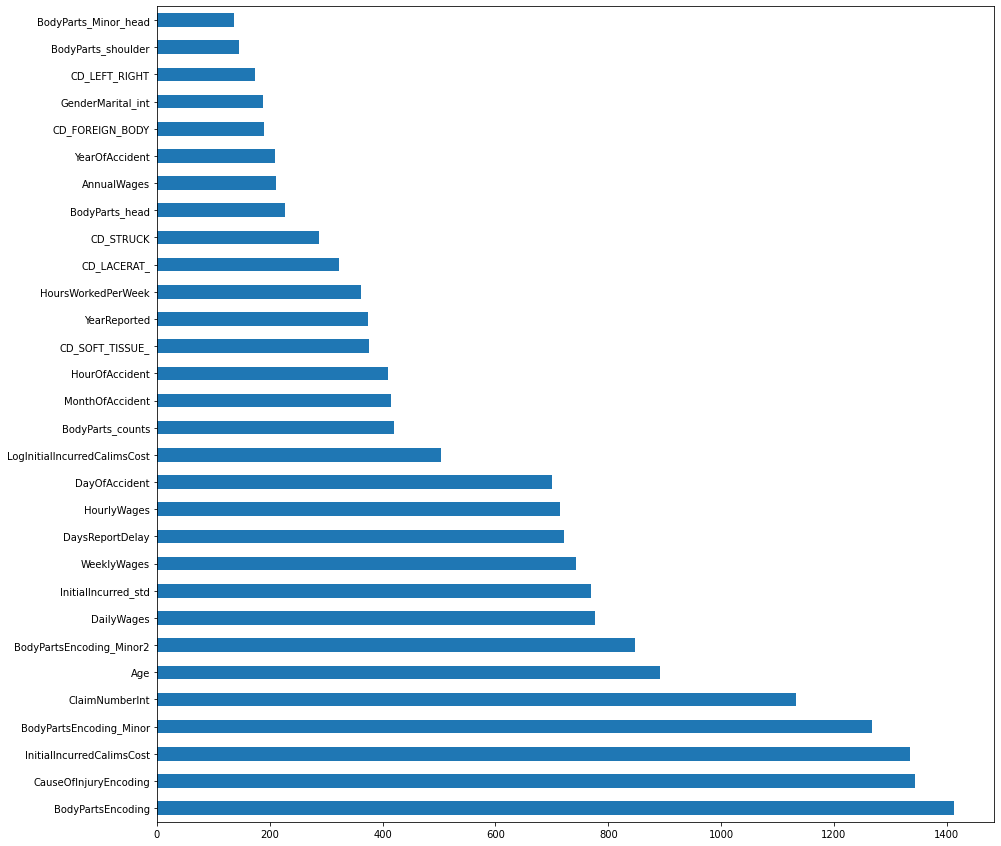

In [108]:
# lightGBM: Plot feature importance
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 15, 15 ### 20, 20  

(pd.Series(LGB.feature_importances_, index=X_train.columns).nlargest(30).plot(kind='barh'))  
plt.show()


### 3.2 XGBoost

In [109]:
#### XGBRegressor: train and predict through CV

X, Xt, y, yt = train_test_split(deepcopy(X_copy), deepcopy(y_copy), test_size=0.1, random_state=SEED)
X.reset_index(inplace=True, drop=True)
Xt.reset_index(inplace=True, drop=True)

import gc
_ = gc.collect()

best_pars_xgb = {'tree_method': 'hist', 'subsample': 0.7, 'n_estimators': 500, 
                 'max_depth': 7, 'learning_rate': 0.02, 'gamma': 0.49, 'colsample_bytree': 0.7}

skf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

# CV 
mse_cv_xgb = list()
oof_xgb = np.zeros(len(X))
cv_val_preds_xgb = np.zeros(len(Xt))
cv_test_preds_xgb = np.zeros(len(X_test))


for train_idx, val_idx in skf.split(X, y):
    X_train, y_train = X.iloc[train_idx, :], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx, :], y.iloc[val_idx]
    
    XGB = XGBRegressor(**best_pars_xgb)
    
    XGB.fit(X_train, y_train, 
           eval_metric='rmse',
           early_stopping_rounds=50, 
           eval_set=[(X_val, y_val)],        
           verbose=False
           )
    
    preds = XGB.predict(X_val)
    oof_xgb[val_idx] = preds
    
    # CV test prediction       
    cv_val_preds_xgb += (np.expm1(XGB.predict(Xt))*1.29) / FOLDS   
    cv_test_preds_xgb += (np.expm1(XGB.predict(X_test))*1.29) / FOLDS   #### Convert back to the original scale as the raw prediction is in log 
    
    result = mean_squared_error(np.expm1(y_val), np.expm1(XGB.predict(X_val))*1.29)  ## when use the tuning pars
    mse_cv_xgb.append(result)


print("XGB model run time (sec):" + "%6.0f" % (time.time() - tic))

##### Avg MSE from CV
print("XGB Average CV MSE %0.3f ± %0.3f" % (np.mean(mse_cv_xgb), np.std(mse_cv_xgb)))
print("XGB Saved 10_percent MSE %0.3f" % mean_squared_error(np.expm1(yt), cv_val_preds_xgb)) 



XGB model run time (sec):   286
XGB Average CV MSE 556753848.637 ± 97586614.153
XGB Saved 10_percent MSE 637002754.336


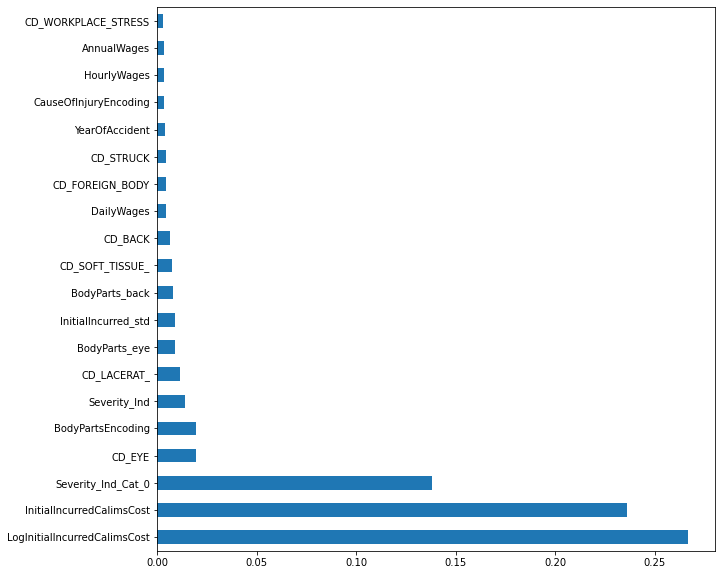

In [110]:
# XGBoost: Plot feature importance
plt.rcParams["figure.figsize"] = 10, 10 

(pd.Series(XGB.feature_importances_, index=X_train.columns).nlargest(20).plot(kind='barh'))
## (pd.Series(XGB.feature_importances_, index=X_train.columns).nlargest(len(X_train.columns)).plot(kind='barh'))  
plt.show()



### 3.3 Model stacking and scoring

In [111]:
# Validation MSE (Stacking LightGBM and XGBoost)
lgb_w, xgb_w = 0.85, 0.15

##### CV train and prediction
predictions_val = (lgb_w * np.expm1(oof)*1.31 + xgb_w * np.expm1(oof_xgb)*1.29)/(lgb_w + xgb_w)
result = mean_squared_error(np.expm1(y), predictions_val)
print("MSE:" + "%6.2f" % result)

MSE:554869698.65


In [ ]:
# CV prediction 
predictions = (lgb_w * cv_test_preds_lgb + xgb_w * cv_test_preds_xgb)/(lgb_w + xgb_w)

In [ ]:
# Write submission file
df_test_pred = pd.DataFrame({'ClaimNumber':ID,'UltimateIncurredClaimCost':predictions})
df_test_pred.to_csv('submission_v3.csv',index=False)
